C:\Users\raghu\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]
Created cyclic encodings for time features
Amount Distribution Analysis:
  Mean: 1.5695, Std: 1.2634
  Skewness: -1.0827, Kurtosis: -0.3416
  Detected 4 peaks at: [-0.82075792 -0.50234715  1.7214741   2.53519052]


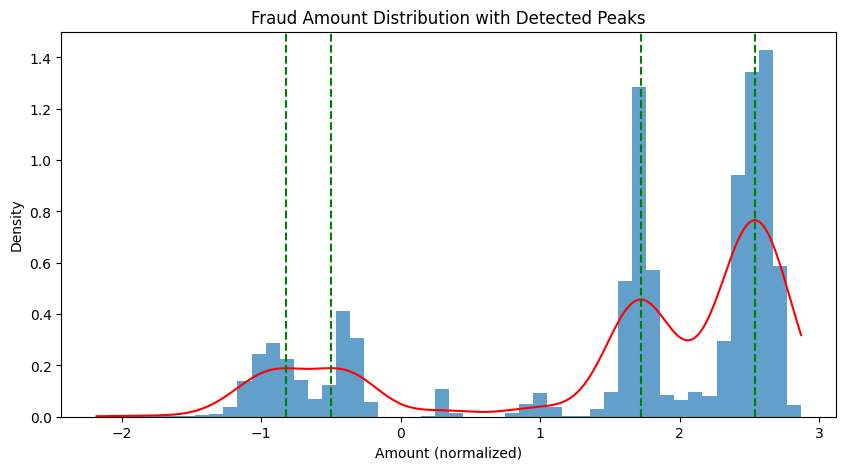

Using device: cuda
Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}


d:\ProgramData\anaconda3\envs\Env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with NaN prevention…
Epoch [1/550], Loss: 9.8894
Epoch [10/550], Loss: 7.3561
Epoch [20/550], Loss: 6.5869
Epoch [30/550], Loss: 6.1726
Epoch [40/550], Loss: 5.8081
Epoch [50/550], Loss: 5.0867
Epoch [60/550], Loss: 4.8698
Epoch [70/550], Loss: 4.4400
Epoch [80/550], Loss: 4.1298
Epoch [90/550], Loss: 4.0563
Epoch [100/550], Loss: 4.1048
Epoch [110/550], Loss: 3.3932
Epoch [120/550], Loss: 3.5103
Epoch [130/550], Loss: 3.2929
Epoch [140/550], Loss: 3.4231
Epoch [150/550], Loss: 3.0949
Epoch [160/550], Loss: 3.1918
Epoch [170/550], Loss: 2.9085
Epoch [180/550], Loss: 2.8970
Epoch [190/550], Loss: 2.6836
Epoch [200/550], Loss: 2.7041
Epoch [210/550], Loss: 2.7714
Epoch [220/550], Loss: 3.0078
Epoch [230/550], Loss: 2.6781
Epoch [240/550], Loss: 2.7702
Epoch [250/550], Loss: 2.9091
Epoch [260/550], Loss: 1.0113
Epoch [270/550], Loss: 1.1237
Epoch [280/550], Loss: 1.1811
Epoch [290/550], Loss: 1.0635
Epoch [300/550], Loss: 1.0149
Epoch [310/550], Loss: 0.9792
Epoch [320/5

C:\Users\raghu\AppData\Local\Temp\ipykernel_79992\2495300234.py:746: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])



Feature: amt
------------------------------------------------------------
KS Statistic: 0.3441, p-value: 0.0000
Anderson–Darling Statistic: 741.7827, significance level: 0.0010
Real Skewness: -1.0827, Synthetic Skewness: 0.0465
Real Kurtosis: -0.3416, Synthetic Kurtosis: -1.6632
------------------------------------------------------------

Feature: lat
------------------------------------------------------------
KS Statistic: 0.0548, p-value: 0.0000
Anderson–Darling Statistic: 17.5759, significance level: 0.0010
Real Skewness: 0.0423, Synthetic Skewness: -0.3138
Real Kurtosis: 1.7822, Synthetic Kurtosis: -0.3184
------------------------------------------------------------

Feature: long
------------------------------------------------------------
KS Statistic: 0.0992, p-value: 0.0000
Anderson–Darling Statistic: 42.4168, significance level: 0.0010
Real Skewness: -1.2104, Synthetic Skewness: -0.8228
Real Kurtosis: 1.9790, Synthetic Kurtosis: 0.5948
--------------------------------------

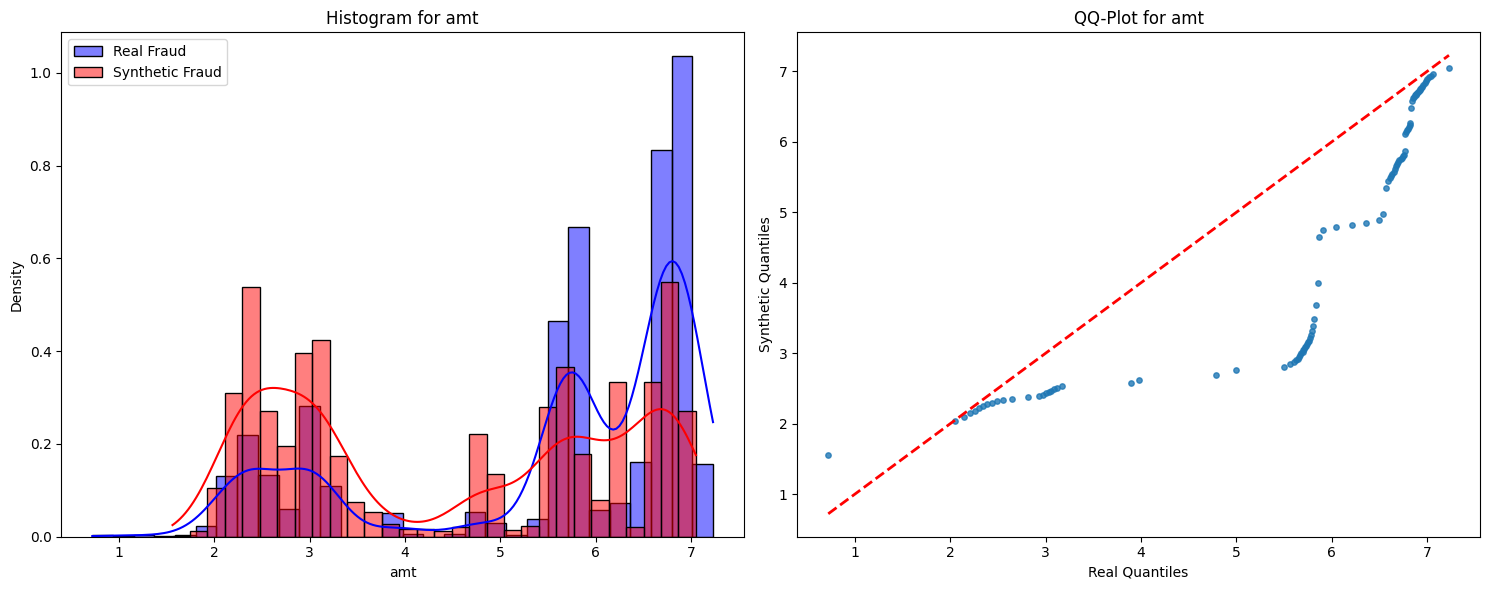

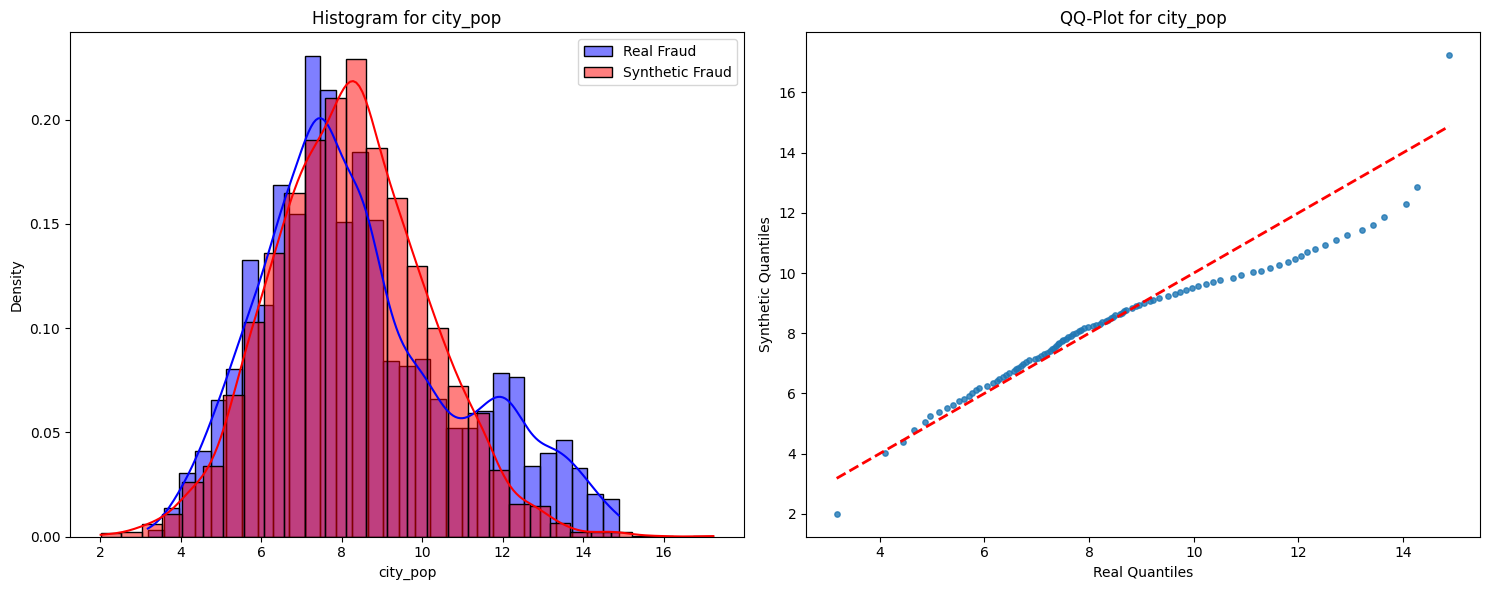

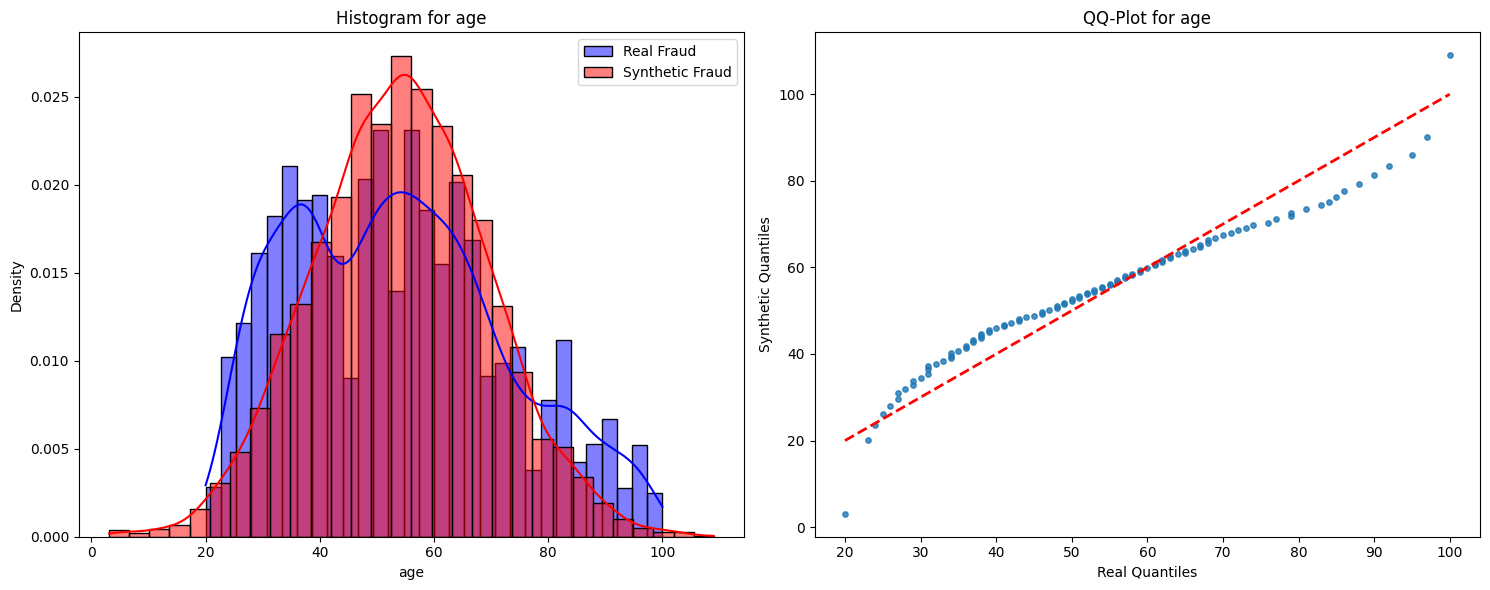

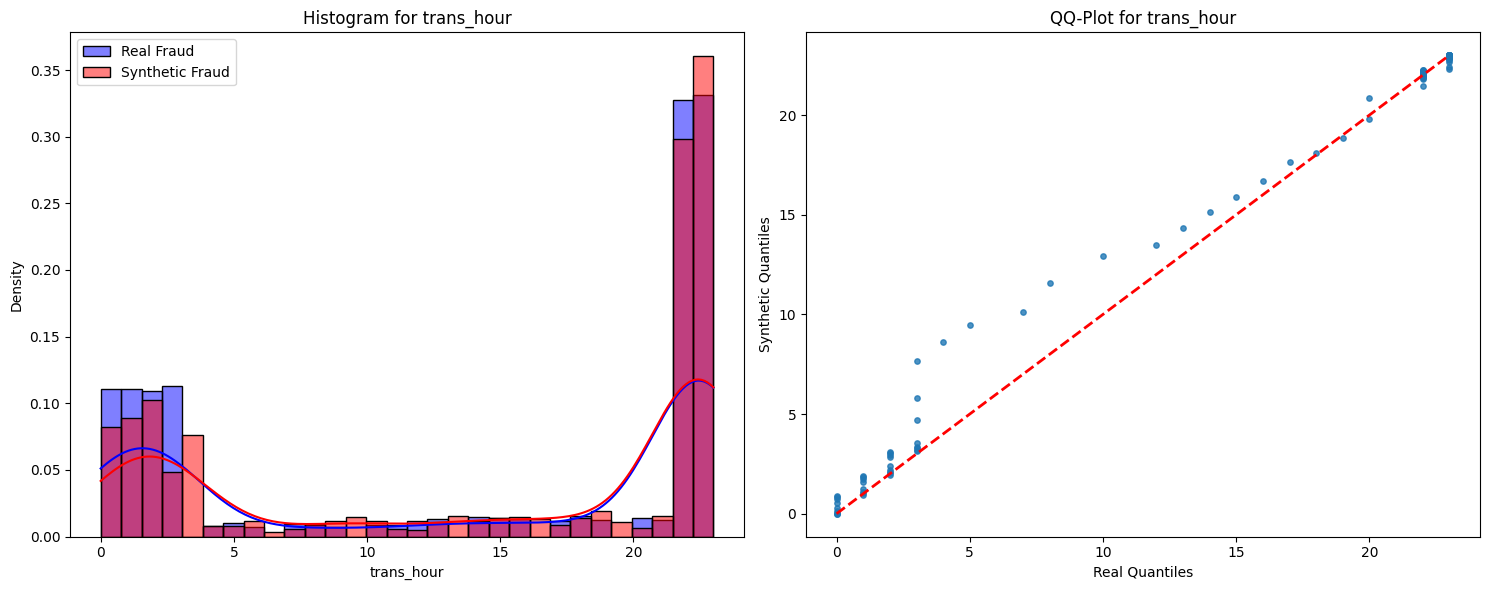

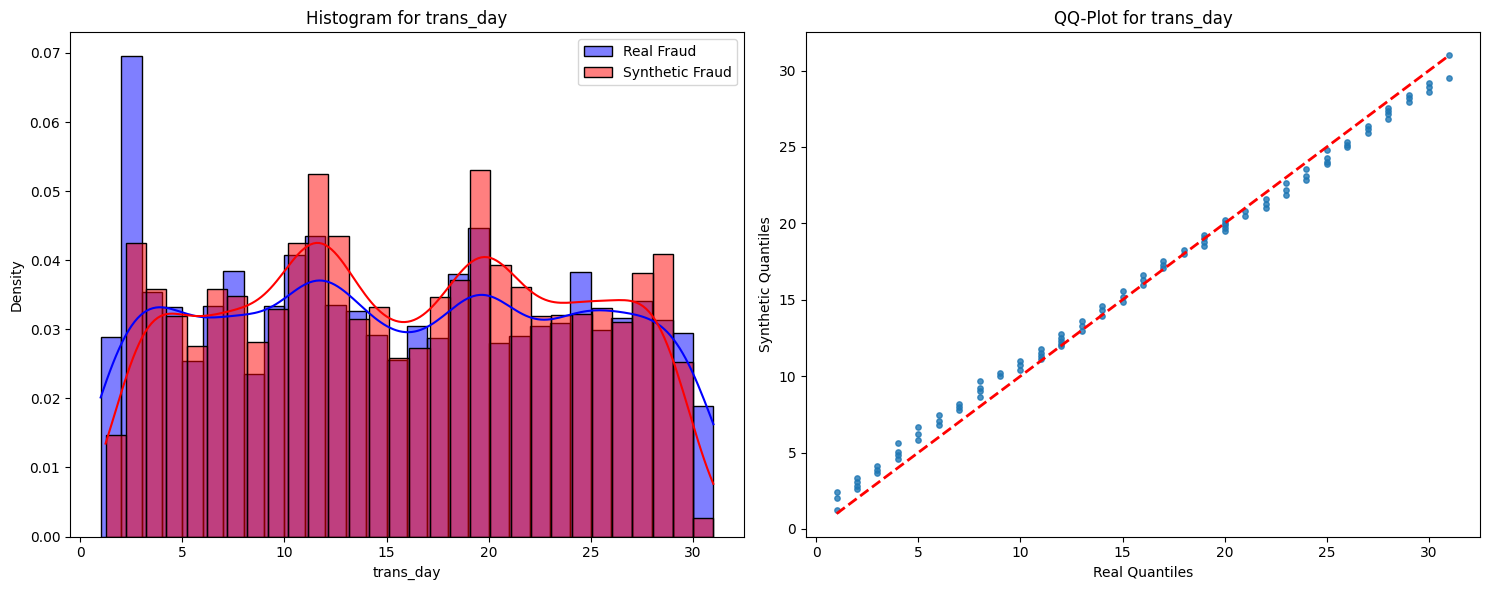

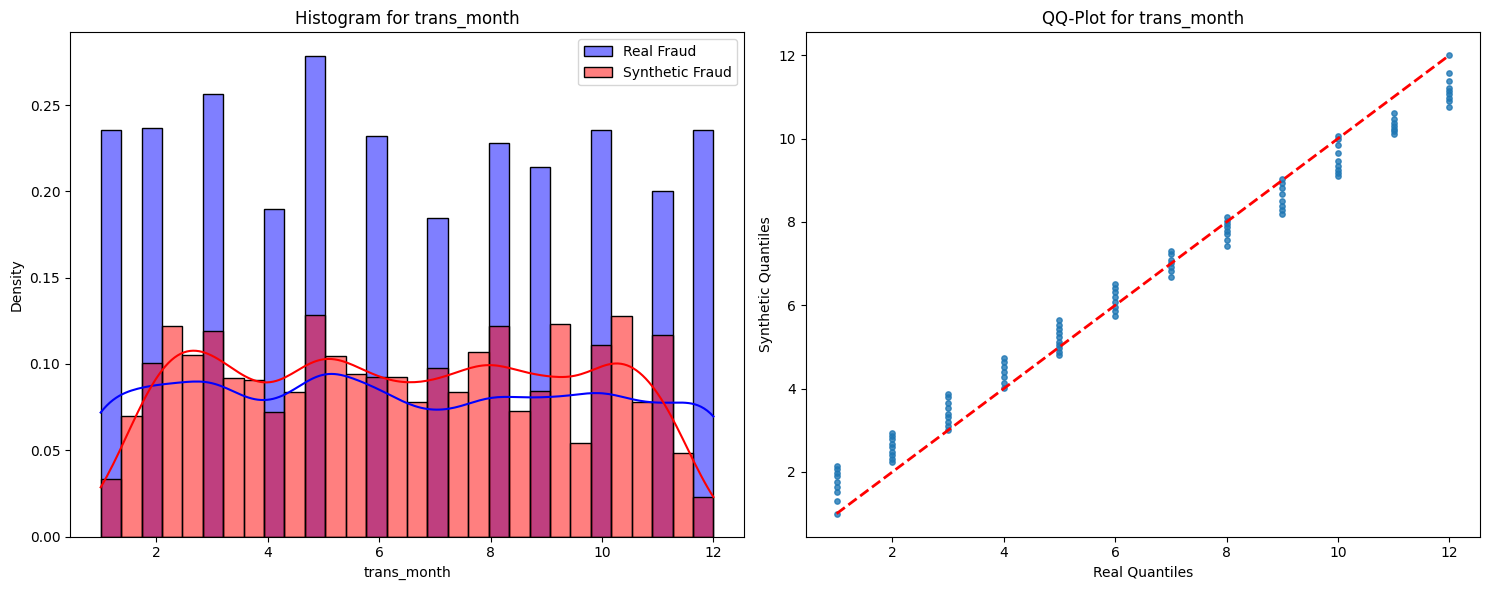

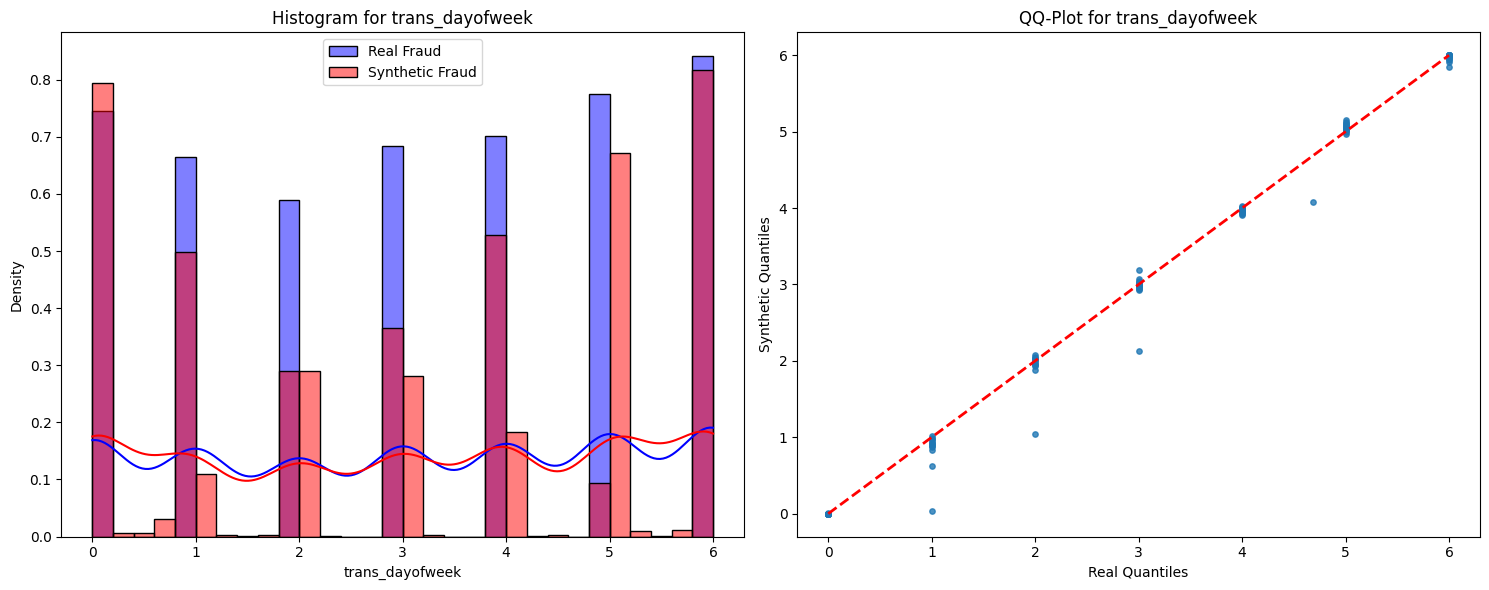

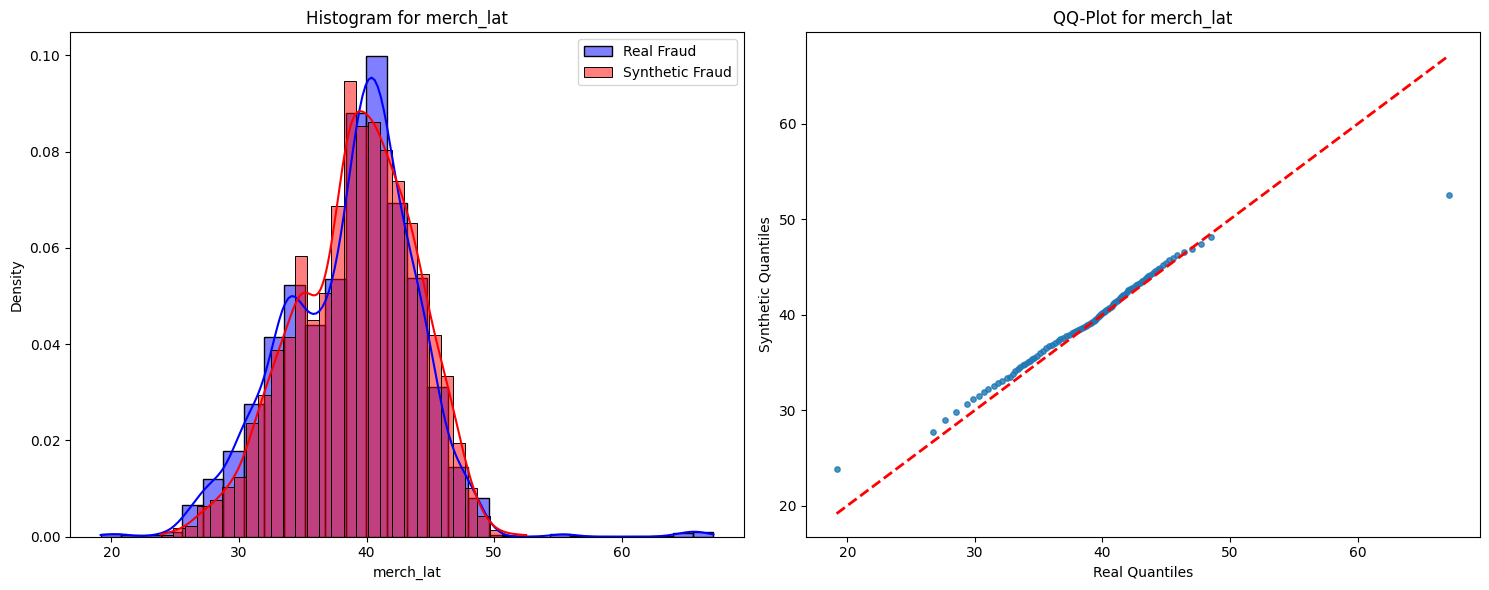

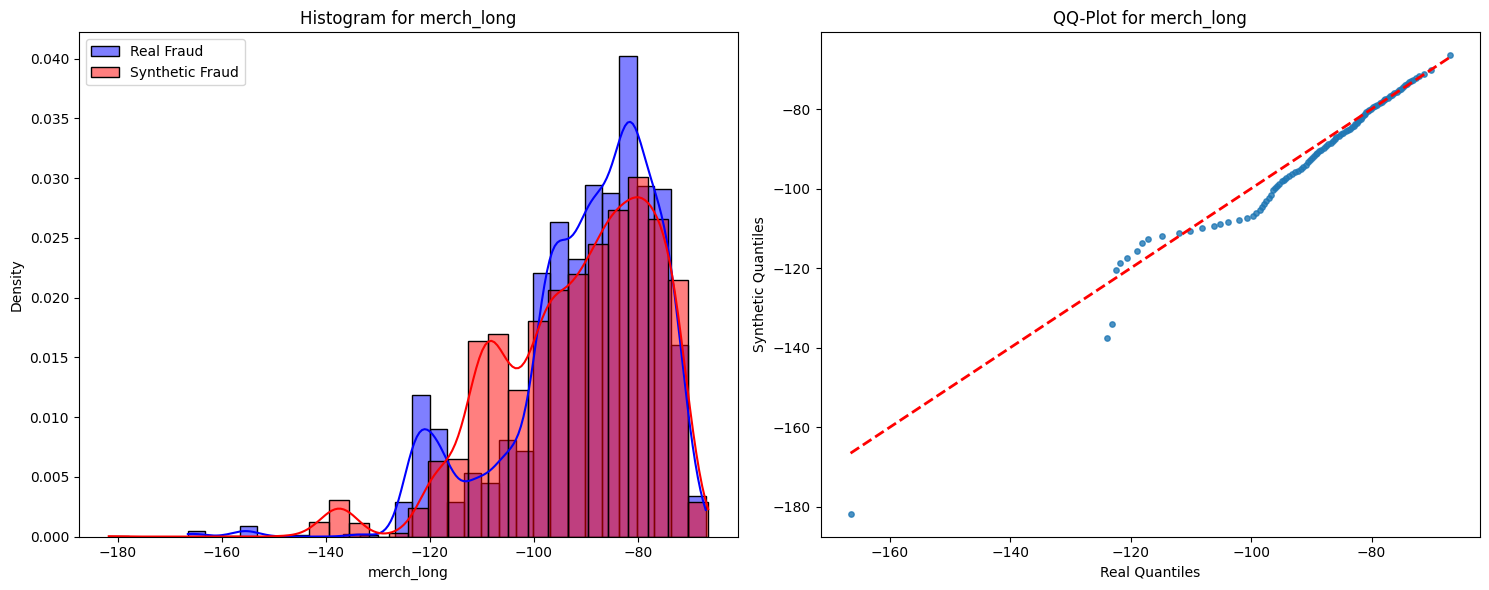

Synthetic data saved to CSV


In [1]:
"""
Improved FraudDiffuse Model – Version 4 with Stable Distribution Matching
Building on v3 with targeted improvements:
  • Controlled distribution matching for amount (amt) feature
  • Stability-preserving model architecture
  • Balanced loss weighting strategy
  • NaN prevention mechanisms 
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
from scipy import stats
from scipy.stats import wasserstein_distance, energy_distance

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
# Use raw strings to avoid escape-sequence issues.
X_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\y_train.csv")

scaler = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_vocab.pkl")
cat_mapping = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists exactly as used during preprocessing.
# All numeric features were standard-scaled.
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Categorical features (factorized)
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Get target values (assume first column in y_train_df is target).
y_train = y_train_df.iloc[:, 0]

# Create masks.
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter training data.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Standard-scaled numeric features.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Integer codes.

X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

#############################################
# Step 1b: Compute observed range for engineered features
#############################################
# Engineered features are those extracted from datetime:
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Find their indices in "numeric_features"
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Also get the index for amt
amt_idx = numeric_features.index('amt')

# Compute column-wise min and max for engineered features from the fraud training set
# (They are in standardized space.)
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
# Convert to torch tensors
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# Create cyclic encodings for time features
def create_cyclic_features(data, feature_indices, periods):
    """Create sine and cosine features for cyclical data"""
    cyclic_data = np.zeros((data.shape[0], len(feature_indices) * 2))
    
    for i, (idx, period) in enumerate(zip(feature_indices, periods)):
        # Normalize to [0, 2π]
        values = data[:, idx].copy()
        normalized = 2 * np.pi * values / period
        
        # Create sin and cos features
        cyclic_data[:, i*2] = np.sin(normalized)
        cyclic_data[:, i*2+1] = np.cos(normalized)
        
    return cyclic_data

# Define periods for each time feature (after inverse transform)
# Note: We estimate the periods based on the feature names
hour_period = 24.0  # 24 hours in a day
day_period = 31.0   # Max days in a month
month_period = 12.0 # 12 months in a year
dow_period = 7.0    # 7 days in a week

periods = [hour_period, day_period, month_period, dow_period]

# Inverse transform the data to get the original scale
X_train_num_original = scaler.inverse_transform(X_train_num)
X_nonfraud_num_original = scaler.inverse_transform(X_nonfraud_num)

# Create cyclic features using original scale data
cyclic_fraud = create_cyclic_features(
    X_train_num_original, 
    [numeric_features.index(feat) for feat in eng_features], 
    periods
)

cyclic_nonfraud = create_cyclic_features(
    X_nonfraud_num_original,
    [numeric_features.index(feat) for feat in eng_features],
    periods
)

print("Created cyclic encodings for time features")

#############################################
# Step 1c: Analyze Amount Distribution
#############################################
# Analyze amount distribution to understand its characteristics
amt_idx = numeric_features.index('amt')
fraud_amts = X_train_num[:, amt_idx]

# Calculate key statistics
amt_mean = np.mean(fraud_amts)
amt_std = np.std(fraud_amts)
amt_skew = stats.skew(fraud_amts)
amt_kurt = stats.kurtosis(fraud_amts)

# Analyze for bimodality
from scipy import stats
from scipy.signal import find_peaks

kde = stats.gaussian_kde(fraud_amts)
x_grid = np.linspace(min(fraud_amts), max(fraud_amts), 1000)
kde_values = kde(x_grid)
peaks, _ = find_peaks(kde_values, height=0.05*kde_values.max())
peak_x = x_grid[peaks]

print(f"Amount Distribution Analysis:")
print(f"  Mean: {amt_mean:.4f}, Std: {amt_std:.4f}")
print(f"  Skewness: {amt_skew:.4f}, Kurtosis: {amt_kurt:.4f}")
print(f"  Detected {len(peak_x)} peaks at: {peak_x}")

# Visualize the distribution
plt.figure(figsize=(10, 5))
plt.hist(fraud_amts, bins=50, density=True, alpha=0.7)
plt.plot(x_grid, kde_values, 'r-')
for px in peak_x:
    plt.axvline(x=px, color='g', linestyle='--')
plt.title("Fraud Amount Distribution with Detected Peaks")
plt.xlabel("Amount (normalized)")
plt.ylabel("Density")
plt.show()

# Store peak information for later use in generation
peak_amounts = peak_x

#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data, cyclic_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        self.cyclic_data = torch.tensor(cyclic_data, dtype=torch.float32)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx], self.cyclic_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat, cyclic_fraud)

#############################################
# Step 3: Set Device and Diffusion Hyperparameters
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

# Increase weight for amount loss - this was too low
w1 = 0.10  # Prior weight
w2 = 0.40  # Triplet loss weight
lambda_eng = 0.05  # Weight for engineered range loss
lambda_amt = 0.15  # Increased from 0.02 to focus more on amount distribution

#############################################
# Step 4: Define the Diffusion Model
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    Enhanced version that handles cyclic time encodings
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cyclic_dim=8, cat_embed_dim=4, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        
        # Now includes cyclic dimensions in the input
        combined_input_dim = num_input_dim + cat_total_dim + cyclic_dim
        
        # Simpler network with gentle residual connections to avoid NaN issues
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, combined_input_dim)
        
        # FIXED: Use LayerNorm for more robust normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        
        # FIXED: Use ReLU for more stability (SiLU can sometimes cause issues)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights carefully to avoid exploding gradients
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        
    def forward(self, x_num, x_cat, x_cyclic, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        
        # Include cyclic features in the concatenation
        x = torch.cat([x_num, x_cat_emb, x_cyclic], dim=1)
        
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        
        # More stable implementation with layer normalization
        h = self.activation(self.fc1(x_input))
        h = self.norm1(h)
        h = self.dropout(h)
        
        h_res = h
        h = self.activation(self.fc2(h))
        h = self.norm2(h)
        h = self.dropout(h)
        h = h + 0.1 * h_res  # Gentle residual connection
        
        h_res = h
        h = self.activation(self.fc3(h))
        h = self.norm3(h)
        h = self.dropout(h)
        h = h + 0.1 * h_res  # Gentle residual connection
        
        out = self.fc4(h)
        
        return out

cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)

num_input_dim = len(numeric_features)
cyclic_dim = len(eng_features) * 2  # sin & cos for each time feature

model = CombinedNoisePredictor(
    num_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cyclic_dim=cyclic_dim,
    cat_embed_dim=4,
    hidden_dim=256  # Reduced from 320 for stability
).to(device)

#############################################
# Step 5: Define Loss Functions, Forward Diffusion, and Feature-Specific Losses
#############################################
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
X_cyclic_nonfraud_tensor = torch.tensor(cyclic_nonfraud, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_feature_weighted_Lnorm(pred_noise, true_noise):
    # Refined feature weights based on v2 results
    feature_weights = torch.ones(num_input_dim, device=device)
    
    # Indices in numeric_features for challenging features
    amt_idx = numeric_features.index('amt')
    hour_idx = numeric_features.index('trans_hour')
    month_idx = numeric_features.index('trans_month')
    dow_idx = numeric_features.index('trans_dayofweek')
    day_idx = numeric_features.index('trans_day')
    
    # Apply weights based on v2 performance, but gentler for stability
    feature_weights[amt_idx] = 1.5      # Adjusted weight for amount
    feature_weights[hour_idx] = 1.3     # Adjusted for trans_hour 
    feature_weights[month_idx] = 1.1    # Slightly increased
    feature_weights[dow_idx] = 1.1      # Slightly increased
    feature_weights[day_idx] = 1.0      # Keeping neutral weight for trans_day
    
    # Weighted MSE
    squared_diff = (pred_noise - true_noise)**2
    weighted_squared_diff = squared_diff * feature_weights.unsqueeze(0)
    return weighted_squared_diff.mean()

# FIXED: Safer Lprior computation that prevents NaN values
def compute_Lprior(pred_noise):
    # Add epsilon to sigma to prevent division by very small values
    z = (pred_noise - mu_nf) / (sigma_nf + 1e-5)
    
    # Clip to prevent extreme values
    z = torch.clamp(z, -10.0, 10.0)
    z_abs = torch.abs(z)
    
    # Handle CDF calculation safely with exception catching
    try:
        normal = torch.distributions.Normal(0, 1)
        prob = 1 - normal.cdf(z_abs)
        L_prior = 1 - 2 * prob
        return L_prior.mean()
    except Exception as e:
        # Fallback to simpler loss if CDF fails
        print(f"CDF calculation failed: {e}. Using fallback loss.")
        return 0.1 * F.mse_loss(pred_noise, torch.zeros_like(pred_noise))

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    # Penalize values below eng_min or above eng_max.
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# FIXED: Much more stable amount distribution loss
def amount_distribution_loss(x0_est_amt, real_amt):
    """Enhanced loss for better bimodal amount distribution matching"""
    # Calculate basic statistical matches
    batch_mean = x0_est_amt.mean()
    real_mean = real_amt.mean()
    mean_diff = (batch_mean - real_mean).abs()
    
    # Get quantiles from both distributions - focus on upper quantiles
    # since this is where we're seeing mismatch
    try:
        # Safely calculate percentiles
        x0_np = x0_est_amt.detach().cpu().numpy()
        real_np = real_amt.detach().cpu().numpy()
        
        # Calculate key percentiles, especially focusing on higher ones
        # for fraud amounts
        x0_q50 = torch.tensor(np.percentile(x0_np, 50)).to(device)
        real_q50 = torch.tensor(np.percentile(real_np, 50)).to(device)
        x0_q75 = torch.tensor(np.percentile(x0_np, 75)).to(device)
        real_q75 = torch.tensor(np.percentile(real_np, 75)).to(device)
        x0_q90 = torch.tensor(np.percentile(x0_np, 90)).to(device)
        real_q90 = torch.tensor(np.percentile(real_np, 90)).to(device)
        x0_q95 = torch.tensor(np.percentile(x0_np, 95)).to(device)
        real_q95 = torch.tensor(np.percentile(real_np, 95)).to(device)
        
        # Compute skewness for both distributions
        # (The fraud amount distribution has negative skew we need to match)
        real_centered = real_np - np.mean(real_np)
        real_skew = np.mean((real_centered / np.std(real_centered))**3)
        
        x0_centered = x0_np - np.mean(x0_np)
        x0_skew = np.mean((x0_centered / (np.std(x0_centered) + 1e-8))**3)
        
        skew_diff = np.abs(real_skew - x0_skew)
        skew_tensor = torch.tensor(skew_diff).to(device)
        
        # Higher weights on the upper percentiles to ensure we match
        # the higher-value fraud distribution
        return mean_diff + \
               1.0 * (x0_q50 - real_q50).abs() + \
               2.0 * (x0_q75 - real_q75).abs() + \
               3.0 * (x0_q90 - real_q90).abs() + \
               4.0 * (x0_q95 - real_q95).abs() + \
               2.0 * skew_tensor
    except Exception as e:
        print(f"Error in percentile calculation: {e}, using mean difference only")
        return mean_diff

#############################################
# Step 6: Train the Diffusion Model (Fraud Samples Only)
#############################################
# IMPROVED: Slightly smaller batch size for initial stability
loader = DataLoader(fraud_dataset, batch_size=32, shuffle=True)
num_epochs = 550  # Reduced from 600
# IMPROVED: Even lower learning rate for stability
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)  # Added weight decay

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=30, verbose=True
)

# Convert real amount data to tensor for use in amount_distribution_loss
X_real_amt = torch.tensor(X_train_num[:, amt_idx], dtype=torch.float32).to(device)

print("Starting training with NaN prevention…")
for epoch in range(num_epochs):
    # Start increasing weights only after model is stable
    if epoch > 200 and epoch % 50 == 0:
        lambda_amt = min(0.05, lambda_amt * 1.1)  # Very gentle increase every 50 epochs

    epoch_loss = 0.0
    num_batches = 0
    
    for batch in loader:
        x0_num, x0_cat, x0_cyclic = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        x0_cyclic = x0_cyclic.to(device)
        batch_size = x0_num.shape[0]
        
        # Skip batches that are too small (can cause std issues)
        if batch_size <= 1:
            continue
            
        # FIXED: Use a more stable t sampling to avoid extreme values
        t = torch.randint(1, T_train-1, (batch_size,), device=device)  # Avoid t=0 and t=T_train-1
        
        # Forward diffusion
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        
        # Check for NaNs
        if torch.isnan(x_t_num).any():
            print("NaN detected in x_t_num, skipping batch")
            continue
            
        # Forward through model
        pred_noise = model(x_t_num, x0_cat, x0_cyclic, t)
        
        # Check for NaNs
        if torch.isnan(pred_noise).any():
            print("NaN detected in pred_noise, skipping batch")
            continue
            
        # Extract predicted noise for numeric features
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        # Safe loss calculations with gradient clipping built-in
        L_norm = compute_feature_weighted_Lnorm(pred_noise_numeric, true_noise)
        
        # Safer version of L_prior
        try:
            L_prior = compute_Lprior(pred_noise_numeric)
            if torch.isnan(L_prior):
                print("NaN in L_prior, using fallback")
                L_prior = 0.1 * torch.mean(pred_noise_numeric**2)
        except Exception as e:
            print(f"Error in L_prior: {e}, using fallback")
            L_prior = 0.1 * torch.mean(pred_noise_numeric**2)
        
        # Calculate x0_est with numerical stability measures
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        
        # Safer x0 estimation with clamping
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / (sqrt_alpha_hat_t + 1e-8)
        x0_est = torch.clamp(x0_est, -10.0, 10.0)  # Prevent extreme values
        
        if torch.isnan(x0_est).any():
            print("NaN detected in x0_est, skipping batch")
            continue
        
        # Get negative samples for triplet loss
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        
        # Compute triplet loss
        try:
            L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
            if torch.isnan(L_triplet):
                print("NaN in L_triplet, using fallback")
                L_triplet = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_triplet: {e}, using fallback")
            L_triplet = torch.tensor(0.0).to(device)
        
        # Compute engineered range loss
        x0_est_eng = x0_est[:, eng_indices]
        try:
            L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
            if torch.isnan(L_eng):
                print("NaN in L_eng, using fallback")
                L_eng = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_eng: {e}, using fallback")
            L_eng = torch.tensor(0.0).to(device)
        
        # Compute amount-specific loss
        x0_est_amt = x0_est[:, amt_idx]
        try:
            L_amt = amount_distribution_loss(x0_est_amt, X_real_amt[:batch_size])
            if torch.isnan(L_amt):
                print("NaN in L_amt, using fallback")
                L_amt = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_amt: {e}, using fallback")
            L_amt = torch.tensor(0.0).to(device)
        
        # Final loss with NaN checking
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng + lambda_amt * L_amt
        
        if torch.isnan(total_loss):
            print("NaN in total_loss, skipping batch")
            continue
            
        optimizer.zero_grad()
        total_loss.backward()
        
        # IMPROVED: Aggressive gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        epoch_loss += total_loss.item()
        num_batches += 1
    
    # Safe average calculation
    avg_loss = epoch_loss / max(1, num_batches)
    
    # Update learning rate based on loss
    scheduler.step(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'baseline_improved_v4_stable.pth' …")
torch.save(model.state_dict(), r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\baseline_improved_v4_stable.pth")
print("Model saved.")

#############################################
# Step 7: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=600):  # Reduced T_gen
    model.eval()
    with torch.no_grad():
        # Create categorical samples
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        
        # IMPROVED: Better initialization with bimodal distribution awareness
        # Create a mixture of two distributions to better match bimodal patterns
        idx1 = torch.randint(0, X_fraud_tensor.shape[0] // 2, (num_samples // 2,), device=device)
        idx2 = torch.randint(X_fraud_tensor.shape[0] // 2, X_fraud_tensor.shape[0], (num_samples - num_samples // 2,), device=device)
        idx = torch.cat([idx1, idx2])
        
        # Add controlled noise
        noise = torch.randn(num_samples, num_input_dim).to(device) * 0.3  # Reduced noise
        x_t_num = X_fraud_tensor[idx] + X_fraud_tensor.std(dim=0, keepdim=True) * noise
        
        # Create cyclic features for generation
        X_cyclic_fraud_tensor = torch.tensor(cyclic_fraud, dtype=torch.float32).to(device)
        x_cyclic = X_cyclic_fraud_tensor[idx]
        
        # IMPROVED: Enhanced handling for amount to better match bimodal distribution
        amt_idx = numeric_features.index('amt')
        
        # Get real fraud amount distribution
        fraud_amts = X_fraud_tensor[:, amt_idx]
        
        # Use KDE to find the peaks in the distribution
        fraud_amts_np = fraud_amts.cpu().numpy()
        kde = stats.gaussian_kde(fraud_amts_np)
        x_grid = np.linspace(fraud_amts_np.min(), fraud_amts_np.max(), 1000)
        kde_values = kde(x_grid)
        
        # Find peaks in the KDE
        peaks, _ = find_peaks(kde_values, height=0.05*kde_values.max())
        peak_x = x_grid[peaks]
        print(f"Found {len(peak_x)} peaks in amount distribution at: {peak_x}")
        
        # If at least two peaks found, use them for initialization
        if len(peak_x) >= 2:
            # Sort peaks to ensure higher amounts are at the end
            peak_x = sorted(peak_x)
            
            # Distribute samples with more weight on higher amounts (where most fraud occurs)
            # 20% for lower peak, 80% for higher peak
            high_peak_samples = int(num_samples * 0.8)
            low_peak_samples = num_samples - high_peak_samples
            
            # Generate samples around each peak with controlled noise
            low_peak = torch.tensor(peak_x[0], device=device)
            high_peak = torch.tensor(peak_x[-1], device=device)
            
            # Add noise scaled to distance between peaks for realistic variation
            peak_distance = high_peak - low_peak
            low_noise = torch.randn(low_peak_samples, device=device) * (0.15 * peak_distance)
            high_noise = torch.randn(high_peak_samples, device=device) * (0.1 * peak_distance)
            
            # Create the bimodal sample
            low_amts = low_peak + low_noise
            high_amts = high_peak + high_noise
            
            # Combine and shuffle
            amt_values = torch.cat([low_amts, high_amts])
            perm = torch.randperm(num_samples)
            amt_values = amt_values[perm]
            
            # Replace the amount values in our initialization
            x_t_num[:, amt_idx] = amt_values
        else:
            # Fallback: use more traditional approach with upper/lower thirds
            sorted_amts, _ = torch.sort(fraud_amts)
            n = sorted_amts.size(0)
            
            # Use mixture of distributions for initialization
            lower_idx = torch.randint(0, n // 3, (num_samples // 5,), device=device)  # 20%
            upper_idx = torch.randint(2 * n // 3, n, (num_samples - num_samples // 5,), device=device)  # 80%
            
            # Combined indices
            amt_indices = torch.cat([lower_idx, upper_idx])
            # Add small noise to prevent exact duplicates
            amt_noise = torch.randn(num_samples, device=device) * 0.1  # Reduced noise
            
            # Replace amount values with our bimodal-aware initialization
            x_t_num[:, amt_idx] = sorted_amts[amt_indices] + amt_noise
        
        # Reverse diffusion process
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            
            # Predict noise
            pred_noise = model(x_t_num, x_cat, x_cyclic, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            
            # Clamp predicted noise to avoid extreme values
            pred_noise_numeric = torch.clamp(pred_noise_numeric, -5.0, 5.0)
            
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            
            # IMPROVED: Adaptive noise reduction
            noise_scale = torch.sqrt(beta_t)
            if t_step < 200:  # Reduce noise in later steps
                noise_scale = noise_scale * (t_step / 200.0)
            
            z = torch.randn_like(x_t_num) * noise_scale if t_step > 1 else torch.zeros_like(x_t_num)
            
            # Update sample with stable computation (avoid division by very small numbers)
            x_t_num = (x_t_num - (beta_t / (sqrt_one_minus_alpha_hat_t + 1e-8)) * pred_noise_numeric) / (sqrt_alpha_t + 1e-8) + z
            
            # Clamp to avoid extreme values
            x_t_num = torch.clamp(x_t_num, -10.0, 10.0)
        
        # After reverse diffusion, clip engineered features to observed range.
        x_t_num_clipped = x_t_num.clone()
        x0_est_eng = x_t_num[:, eng_indices]
        x0_est_eng = torch.max(torch.min(x0_est_eng, eng_max.unsqueeze(0)), eng_min.unsqueeze(0))
        x_t_num_clipped[:, eng_indices] = x0_est_eng
        
        return x_t_num_clipped, x_cat


# Generate synthetic samples
num_synthetic = 5000
print("Generating synthetic samples...")
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

#############################################
# Step 8: Inverse Transform Numeric Features to Original Scale
#############################################
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

#############################################
# Step 9: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=numeric_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_numeric = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_numeric, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())

#############################################
# Step 10: Enhanced Distribution Evaluation
#############################################
def calculate_tail_statistics(real, synth):
    """Calculate comprehensive distribution comparison metrics"""
    return {
        'wasserstein': wasserstein_distance(real, synth),
        'energy': energy_distance(real, synth),
        'tail_ratio_95': np.quantile(synth, 0.95)/np.quantile(real, 0.95),
        'tail_ratio_99': np.quantile(synth, 0.99)/np.quantile(real, 0.99),
        'mean_ratio': np.mean(synth)/np.mean(real),
        'std_ratio': np.std(synth)/np.std(real),
        'skew_real': stats.skew(real),
        'skew_synth': stats.skew(synth)
    }

print("\nEnhanced Statistical Comparison")
print("============================================================")

for col in numeric_features:
    real_data = real_numeric_df[col].values
    syn_data = synthetic_numeric_df[col].values
    
    # Statistical tests
    ks_result = stats.ks_2samp(real_data, syn_data)
    try:
        ad_result = stats.anderson_ksamp([real_data, syn_data])
        ad_stat = ad_result.statistic
        ad_signif = ad_result.significance_level
    except:
        ad_stat = float('nan')
        ad_signif = float('nan')
    
    # Calculate distribution statistics
    tail_stats = calculate_tail_statistics(real_data, syn_data)
    
    print(f"\nFeature: {col}")
    print("------------------------------------------------------------")
    print(f"KS Statistic: {ks_result.statistic:.4f}, p-value: {ks_result.pvalue:.4f}")
    print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_signif:.4f}")
    print(f"Real Skewness: {tail_stats['skew_real']:.4f}, Synthetic Skewness: {tail_stats['skew_synth']:.4f}")
    print(f"Real Kurtosis: {stats.kurtosis(real_data):.4f}, Synthetic Kurtosis: {stats.kurtosis(syn_data):.4f}")
    print("------------------------------------------------------------")

#############################################
# Step 11: Visualizations
#############################################
for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek', 'merch_lat', 'merch_long']:
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    # QQ plot
    plt.subplot(1, 2, 2)
    
    # Get real and synthetic data for this feature
    real_data = real_numeric_df[col].values
    syn_data = synthetic_numeric_df[col].values
    
    # Compute the quantiles
    quantiles_real = np.percentile(real_data, np.linspace(0, 100, 100))
    quantiles_syn = np.percentile(syn_data, np.linspace(0, 100, 100))
    
    # Plot the QQ plot
    plt.scatter(quantiles_real, quantiles_syn, alpha=0.8, s=15)
    plt.plot([min(quantiles_real), max(quantiles_real)], 
             [min(quantiles_real), max(quantiles_real)], 
             'r--', linewidth=2)
    
    plt.title(f"QQ-Plot for {col}")
    plt.xlabel("Real Quantiles")
    plt.ylabel("Synthetic Quantiles")
    
    plt.tight_layout()
    plt.show()

# Save the synthetic data
synthetic_full_df.to_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\synthetic_fraud_v4_stable.csv", index=False)
print("Synthetic data saved to CSV")